Simple model to know the framework

In [ ]:
# import all the necessary libraries
import os
import random
import torch
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [ ]:
data_transforms = transforms.Compose([
    transforms.Resize(size=(56, 56)),
    transforms.ToTensor(),
])

# Set up the data directory
data_dir = "Pediatric Chest X-ray Pneumonia/"

# Load the datasets
train_dataset = datasets.ImageFolder(data_dir+"train/", transform=data_transforms)
test_dataset = datasets.ImageFolder(data_dir+"test/", transform=data_transforms)

# Create the data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

# Create the model and optimizer
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(3 * 56 * 56, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 2)
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
model.train()
for epoch in range(3):
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
 
    print(f"Epoch [{epoch + 1}]: Train Loss: {running_loss / len(train_loader):.4f}")  

# Evaluate the model on the test set
correct = 0
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the test set: {correct / len(test_dataset):.2%}")

# EDA

Visualize and understand the dataset's properties, including data distribution, class imbalance, and data quality.

In [ ]:
def visualize_class_distribution(dataset, dataset_name):
    class_counts = np.zeros(len(dataset.classes))
    for _, y in dataset:
        class_counts[y] += 1

    plt.bar(dataset.classes, class_counts)
    plt.xlabel("Class")
    plt.ylabel("Number of images")
    plt.title(f"Class distribution in the {dataset_name} dataset")
    plt.show()

def calculate_dataset_stats(dataset):
    mean = 0.0
    std = 0.0
    for x, _ in dataset:
        mean += x.mean()
        std += x.std()
    
    mean /= len(dataset)
    std /= len(dataset)

    return mean.item(), std.item()

visualize_class_distribution(train_dataset, "Train")
mean, std = calculate_dataset_stats(train_dataset)
print(f"Train dataset mean: {mean:.4f}, standard deviation: {std:.4f}")

visualize_class_distribution(test_dataset, "Test")
mean, std = calculate_dataset_stats(test_dataset)
print(f"Test dataset mean: {mean:.4f}, standard deviation: {std:.4f}")

## Calculate F1 score
F1 score is mean of precision and recall.

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Initialize empty lists to store true labels and predictions
true_labels = []
predicted_labels = []
correct = 0

# Accumulate true labels and predictions for all mini-batches in the test set
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the test set: {correct / len(test_dataset):.2%}")

# Calculate precision, recall, and F1 score using the accumulated true labels and predictions
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 score: {f1:.2f}")

## Confusion Matrix
A confusion matrix is a table that displays the number of true positives, true negatives, false positives, and false negatives for each class

In [ ]:
# Calculate the confusion matrix using the accumulated true labels and predictions
cm = confusion_matrix(true_labels, predicted_labels)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Pneumonia"])
disp.plot()

**Based on the confusion matrix you provided, we can make the following observations about the model**

`1. High sensitivity (Recall) for the Pneumonia class:`
The model is able to correctly identify a large majority of pneumonia cases **(385 out of 390)**, meaning that it has a high true positive rate for the Pneumonia class. This is important in medical applications, as you would want the model to have a low false negative rate, which could lead to missed diagnoses.

`2. Lower precision for the Normal class:`
The model incorrectly classifies a significant number of normal images as pneumonia **(162 out of 234)**. This means that the precision for the Normal class is relatively low. In a medical context, this would lead to a higher false positive rate, which could result in unnecessary further testing or treatment for patients who do not have pneumonia.

`3. Imbalanced classification:`
The model performs better in identifying the Pneumonia class than the Normal class. This could be due to class imbalance in the dataset, where there might be more Pneumonia images than Normal images. This can lead the model to be biased towards the majority class.

# Pytorch Lightning training

# import necessary libraries

In [4]:
import logging
import numpy as np
import pprint
import time
from modules.check_solution import *
import warnings
warnings.filterwarnings("ignore")

import yaml

with open("modules/h.yaml", "r") as file:
    h = yaml.safe_load(file)

Running solution 1/5
CPU cores: 20, Device: cuda, GPU: NVIDIA GeForce RTX 3090
Hyperparameters:
{   'balance': True,
    'batch_size': 64,
    'early_stopping_patience': 'float("inf")',
    'fc1_size': 512,
    'image_size': 224,
    'lr': 0.001,
    'model': 'efficientnetv2',
    'num_epochs': 10,
    'scheduler': 'CosineAnnealingLR10',
    'use_best_checkpoint': False}


2024-03-12 00:13:11.238755: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 00:13:11.238772: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 00:13:11.239311: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1/10: Validation Loss = 4.3417, Train Loss not available, Epoch Time: 0m 31s, Remaining Time: 4m 35s


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2/10: Validation Loss = 0.0862, Train Loss = 0.3682, Epoch Time: 0m 30s, Remaining Time: 3m 57s


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3/10: Validation Loss = 0.0449, Train Loss = 0.1151, Epoch Time: 0m 29s, Remaining Time: 3m 22s


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4/10: Validation Loss = 0.0692, Train Loss = 0.1026, Epoch Time: 0m 29s, Remaining Time: 2m 53s


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5/10: Validation Loss = 0.1061, Train Loss = 0.0725, Epoch Time: 0m 29s, Remaining Time: 2m 24s


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6/10: Validation Loss = 0.0356, Train Loss = 0.0598, Epoch Time: 0m 29s, Remaining Time: 1m 55s


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7/10: Validation Loss = 0.0401, Train Loss = 0.0525, Epoch Time: 0m 29s, Remaining Time: 1m 26s


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8/10: Validation Loss = 0.0372, Train Loss = 0.0380, Epoch Time: 0m 29s, Remaining Time: 0m 57s


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9/10: Validation Loss = 0.0323, Train Loss = 0.0334, Epoch Time: 0m 29s, Remaining Time: 0m 29s


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10/10: Validation Loss = 0.0502, Train Loss = 0.0310, Epoch Time: 0m 29s, Remaining Time: 0m 00s


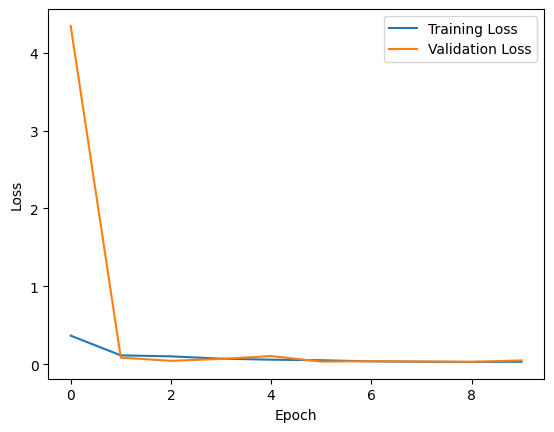

Testing: |          | 0/? [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

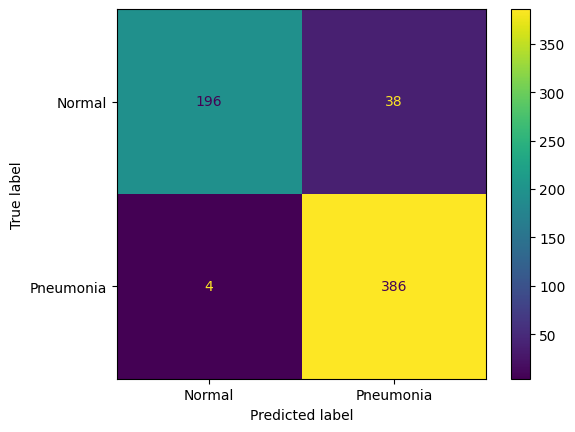

Best: F1= 0.9484, Acc= 0.9339
F1 = 0.95, accuracy = 0.93 
Running solution 2/5
CPU cores: 20, Device: cuda, GPU: NVIDIA GeForce RTX 3090
Hyperparameters:
{   'balance': True,
    'batch_size': 64,
    'early_stopping_patience': 'float("inf")',
    'fc1_size': 512,
    'image_size': 224,
    'lr': 0.001,
    'model': 'efficientnetv2',
    'num_epochs': 10,
    'scheduler': 'CosineAnnealingLR10',
    'use_best_checkpoint': False}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1/10: Validation Loss = 1.0979, Train Loss not available, Epoch Time: 0m 29s, Remaining Time: 4m 23s


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2/10: Validation Loss = 0.1016, Train Loss = 0.2806, Epoch Time: 0m 29s, Remaining Time: 3m 51s


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3/10: Validation Loss = 0.1205, Train Loss = 0.1190, Epoch Time: 0m 29s, Remaining Time: 3m 22s


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4/10: Validation Loss = 0.2168, Train Loss = 0.0907, Epoch Time: 0m 29s, Remaining Time: 2m 52s


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5/10: Validation Loss = 0.0844, Train Loss = 0.0621, Epoch Time: 0m 28s, Remaining Time: 2m 22s


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6/10: Validation Loss = 0.1045, Train Loss = 0.0523, Epoch Time: 0m 28s, Remaining Time: 1m 54s


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7/10: Validation Loss = 0.1162, Train Loss = 0.0460, Epoch Time: 0m 29s, Remaining Time: 1m 26s


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8/10: Validation Loss = 0.1245, Train Loss = 0.0308, Epoch Time: 0m 28s, Remaining Time: 0m 57s


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9/10: Validation Loss = 0.0980, Train Loss = 0.0335, Epoch Time: 0m 28s, Remaining Time: 0m 28s


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10/10: Validation Loss = 0.1139, Train Loss = 0.0214, Epoch Time: 0m 28s, Remaining Time: 0m 00s


Testing: |          | 0/? [00:00<?, ?it/s]

Best: F1= 0.9532, Acc= 0.9401
F1 = 0.95, accuracy = 0.94 
Running solution 3/5
CPU cores: 20, Device: cuda, GPU: NVIDIA GeForce RTX 3090
Hyperparameters:
{   'balance': True,
    'batch_size': 64,
    'early_stopping_patience': 'float("inf")',
    'fc1_size': 512,
    'image_size': 224,
    'lr': 0.001,
    'model': 'efficientnetv2',
    'num_epochs': 10,
    'scheduler': 'CosineAnnealingLR10',
    'use_best_checkpoint': False}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1/10: Validation Loss = 2.4958, Train Loss not available, Epoch Time: 0m 30s, Remaining Time: 4m 26s


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2/10: Validation Loss = 0.0801, Train Loss = 0.3443, Epoch Time: 0m 29s, Remaining Time: 3m 52s


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3/10: Validation Loss = 0.0825, Train Loss = 0.1181, Epoch Time: 0m 29s, Remaining Time: 3m 21s


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4/10: Validation Loss = 0.0533, Train Loss = 0.0851, Epoch Time: 0m 29s, Remaining Time: 2m 52s


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5/10: Validation Loss = 0.1030, Train Loss = 0.0854, Epoch Time: 0m 29s, Remaining Time: 2m 23s


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6/10: Validation Loss = 0.0945, Train Loss = 0.0646, Epoch Time: 0m 29s, Remaining Time: 1m 54s


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7/10: Validation Loss = 0.0447, Train Loss = 0.0519, Epoch Time: 0m 29s, Remaining Time: 1m 26s


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8/10: Validation Loss = 0.0511, Train Loss = 0.0346, Epoch Time: 0m 29s, Remaining Time: 0m 57s


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9/10: Validation Loss = 0.0423, Train Loss = 0.0351, Epoch Time: 0m 28s, Remaining Time: 0m 28s


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10/10: Validation Loss = 0.0427, Train Loss = 0.0281, Epoch Time: 0m 28s, Remaining Time: 0m 00s


Testing: |          | 0/? [00:00<?, ?it/s]

Best: F1= 0.9380, Acc= 0.9198
F1 = 0.94, accuracy = 0.92 
Running solution 4/5
CPU cores: 20, Device: cuda, GPU: NVIDIA GeForce RTX 3090
Hyperparameters:
{   'balance': True,
    'batch_size': 64,
    'early_stopping_patience': 'float("inf")',
    'fc1_size': 512,
    'image_size': 224,
    'lr': 0.001,
    'model': 'efficientnetv2',
    'num_epochs': 10,
    'scheduler': 'CosineAnnealingLR10',
    'use_best_checkpoint': False}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1/10: Validation Loss = 0.5245, Train Loss not available, Epoch Time: 0m 30s, Remaining Time: 4m 33s


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2/10: Validation Loss = 0.1220, Train Loss = 0.2682, Epoch Time: 0m 30s, Remaining Time: 3m 58s


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3/10: Validation Loss = 2.4690, Train Loss = 0.1636, Epoch Time: 0m 29s, Remaining Time: 3m 24s


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4/10: Validation Loss = 6.6821, Train Loss = 0.2320, Epoch Time: 0m 29s, Remaining Time: 2m 54s


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5/10: Validation Loss = 0.3817, Train Loss = 0.1188, Epoch Time: 0m 29s, Remaining Time: 2m 25s


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6/10: Validation Loss = 0.0785, Train Loss = 0.3599, Epoch Time: 0m 29s, Remaining Time: 1m 56s


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7/10: Validation Loss = 0.1553, Train Loss = 0.0936, Epoch Time: 0m 29s, Remaining Time: 1m 27s


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8/10: Validation Loss = 0.1153, Train Loss = 0.1099, Epoch Time: 0m 29s, Remaining Time: 0m 58s


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9/10: Validation Loss = 0.0897, Train Loss = 0.0925, Epoch Time: 0m 29s, Remaining Time: 0m 29s


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10/10: Validation Loss = 0.0943, Train Loss = 0.1180, Epoch Time: 0m 29s, Remaining Time: 0m 00s


Testing: |          | 0/? [00:00<?, ?it/s]

Best: F1= 0.9461, Acc= 0.9307
F1 = 0.95, accuracy = 0.93 
Running solution 5/5
CPU cores: 20, Device: cuda, GPU: NVIDIA GeForce RTX 3090
Hyperparameters:
{   'balance': True,
    'batch_size': 64,
    'early_stopping_patience': 'float("inf")',
    'fc1_size': 512,
    'image_size': 224,
    'lr': 0.001,
    'model': 'efficientnetv2',
    'num_epochs': 10,
    'scheduler': 'CosineAnnealingLR10',
    'use_best_checkpoint': False}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1/10: Validation Loss = 1.2217, Train Loss not available, Epoch Time: 0m 30s, Remaining Time: 4m 28s


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2/10: Validation Loss = 0.4389, Train Loss = 0.3091, Epoch Time: 0m 29s, Remaining Time: 3m 55s


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3/10: Validation Loss = 0.1352, Train Loss = 0.1360, Epoch Time: 0m 29s, Remaining Time: 3m 24s


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4/10: Validation Loss = 0.6200, Train Loss = 0.0826, Epoch Time: 0m 29s, Remaining Time: 2m 55s


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5/10: Validation Loss = 0.0630, Train Loss = 0.1793, Epoch Time: 0m 29s, Remaining Time: 2m 25s


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6/10: Validation Loss = 0.0837, Train Loss = 0.0879, Epoch Time: 0m 29s, Remaining Time: 1m 56s


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7/10: Validation Loss = 0.0604, Train Loss = 0.0647, Epoch Time: 0m 29s, Remaining Time: 1m 27s


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8/10: Validation Loss = 0.0390, Train Loss = 0.0546, Epoch Time: 0m 29s, Remaining Time: 0m 58s


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9/10: Validation Loss = 0.1404, Train Loss = 0.0556, Epoch Time: 0m 29s, Remaining Time: 0m 29s


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10/10: Validation Loss = 0.0616, Train Loss = 0.0355, Epoch Time: 0m 29s, Remaining Time: 0m 00s


Testing: |          | 0/? [00:00<?, ?it/s]

Best: F1= 0.9556, Acc= 0.9432
F1 = 0.96, accuracy = 0.94 
Results
F1: 94.8% (+-0.6%)
Accuracy: 93.4% (+-0.8%)
Time of one solution: 4m 49s
 | 94.8% (+-0.6%) | 93.4% (+-0.8%) | 4m 49s
Hyperparameters:
{   'balance': True,
    'batch_size': 64,
    'early_stopping_patience': 'float("inf")',
    'fc1_size': 512,
    'image_size': 224,
    'lr': 0.001,
    'model': 'efficientnetv2',
    'num_epochs': 10,
    'scheduler': 'CosineAnnealingLR10',
    'use_best_checkpoint': False}


In [5]:
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

f1_array = np.array([])
accuracy_array = np.array([])
start_time = time.time()

repeats = 5
for i in range(repeats):
    print("===============================================")
    print(f"Running solution {i+1}/{repeats}")
    f1, accuracy = check_solution(h, verbose=(i==0))
    print(f"F1 = {f1:.2f}, accuracy = {accuracy:.2f} ")
    f1_array = np.append(f1_array, f1)
    accuracy_array = np.append(accuracy_array, accuracy) 

# Calculate elapsed time and remaining time
repeat_time = (time.time() - start_time) / repeats
repeat_time_min, repeat_time_sec = divmod(repeat_time, 60)

# Printing final results
print("Results")
print(f"F1: {np.mean(f1_array):.1%} (+-{np.std(f1_array):.1%})")
print(f"Accuracy: {np.mean(accuracy_array):.1%} (+-{np.std(accuracy_array):.1%})")
print(f"Time of one solution: {repeat_time_min:.0f}m {repeat_time_sec:.0f}s")
print(f" | {np.mean(f1_array):.1%} (+-{np.std(f1_array):.1%}) | {np.mean(accuracy_array):.1%} (+-{np.std(accuracy_array):.1%}) | {repeat_time_min:.0f}m {repeat_time_sec:.0f}s")

# Print hyperparameters for reminding what the final data is for
print("Hyperparameters:")
pprint.pprint(h, indent=4)